##  Monty Hall problem

In this notebook we will explore the Monty Hall problem and we will solve
it using Pyro.

Watch this [video](https://www.youtube.com/watch?v=4Lb-6rxZxx0) if you don't
know about this problem. You can also read more about its history in the
[wikipedia](https://en.wikipedia.org/wiki/Monty_Hall_problem) page.

TODO:
* infer_discrete

In [1]:
import daft
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
from pyro.infer import Importance, EmpiricalMarginal
from typing import List
from collections import Counter

pyro.set_rng_seed(101)
pyro.enable_validation(True)

At first glance it is not that easy to note that the best strategy is
always to switch to the other door but from the video we learned that the
the problem can be solved analytically.

Here we are going to use Pyro (a probabilistic programming tool) to solve this
probality problem automatically.

Pyro requieres that we program the generative process of the data (the
model) using its semantics. Then we condition our program on
the observed variables which are the constestant's door and the host's door.
With this information we can run an approximate inference algorithm to get
a probability distribution over the unobserved variable (the prize's door).

The generative process of this problem is the following
1. The prize is placed behind one of the 3 doors at random. This information
is only available to the host.
2. The contestant select one of the doors without open it. The host observes
the selected door.
3. The host choose a door that doesn't contain the prize and different from
the contestant's door.
4. Finally, the contestan has to choose between keeping her initial choice or
pick the remaining door.

The most interesting part of the program is the where we calculate the
probability of a door will be opened by the host. This code is in the following
function.

In [2]:
def host_conditional_probs(prize_door: int,
                           contestant_door: int) -> List[float]:
    """Given the location of the prize and the door selected
    by the contestant this function returns a list of the
    probabilities of the host opening the remaining doors."""
    if prize_door == contestant_door:
        probs = [0.5, 0.5, 0.5]
        probs[contestant_door] = 0.
        return probs
    probs = [1., 1., 1.]
    probs[contestant_door] = 0.
    probs[prize_door] = 0.
    return probs

Now we test this function in two different scenarios to see the possible
choices of the host:
* When the contestant selects the door with the prize
* When the contestant selects a door without the prize

In [3]:
# door ∈ {0, 1, 2}
prize_door = 0
contestant_door = 0
assert host_conditional_probs(prize_door, contestant_door) == [0, 0.5, 0.5]

prize_door = 0
contestant_door = 1
assert host_conditional_probs(prize_door, contestant_door) == [0, 0, 1]

As you can see when the prize and the contestant's door are different the host
only has one possible, so its choice is deterministic.

We can describe the problem as the following probabilistic graphical model
where the nodes represent random variables.

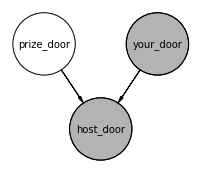

In [10]:
pgm = daft.PGM()
pgm.add_node("prize", "prize_door", 0.5, 2, scale=2.2)
pgm.add_node("contestant", "your_door", 2.5, 2, scale=2.2, observed=True)
pgm.add_node("host", "host_door", 1.5, 0.5, scale=2.2, observed=True)
pgm.add_edge("prize", "host")
pgm.add_edge("contestant", "host")
pgm.render();

In this DAG (directed acyclic graph) the shaded regions are observed variables
from the contestant's perspective

The model is the following

In [13]:
def monty_hall_model(contestant_door: int):
    """Monty Hall model"""
    probs_loc_prize = torch.tensor([1/3, 1/3, 1/3])
    # assign the prize to a door with equal probability
    prize_door = pyro.sample('prize_door', dist.Categorical(probs_loc_prize))
    host_probs = host_conditional_probs(int(prize_door), contestant_door)
    pyro.sample('host_door', dist.Categorical(torch.tensor(host_probs)))
    return prize_door


contestant_door = 0
host_door = 1
# the doors have to be different
assert contestant_door != host_door

# Conditioned model on host's door
cond_model = pyro.condition(
    monty_hall_model, data={"host_door": torch.tensor(host_door)}
)

# approximate inference
n_samples = 1000
traces = pyro.infer.Importance(cond_model, num_samples=n_samples).run(contestant_door)
prize_marginal = pyro.infer.EmpiricalMarginal(traces, "prize_door")
samples = [prize_marginal().detach().item() for _ in range(n_samples)]

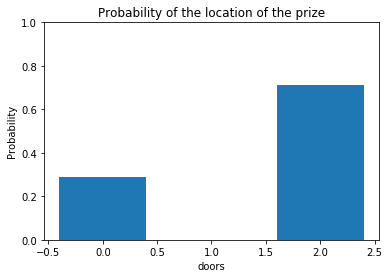

In [14]:
def prize_prob_plot(samples: List[int]):
    doors = [0, 1, 2]
    counter = Counter(samples)
    probs = [counter.get(d, 0) / len(samples) for d in doors]
    fig, ax = plt.subplots(1, 1)
    ax.bar(doors, probs)
    ax.set_title('Probability of the location of the prize')
    ax.set_xlabel('doors')
    ax.set_ylabel('Probability')
    ax.set_ylim(0, 1)

prize_prob_plot(samples)

According to the plot there is higher probability that the prize is behind door number 2. 
Change the initial doors |

### Bonus: infer_discrete

In [ ]:
from pyro.infer import config_enumerate, infer_discrete

